In [1]:
import pandas as po
import matplotlib.pyplot as plt

In [2]:
df = po.read_csv('data/kresit_main_2018-oct_to_2019-oct.csv')

In [3]:
df['Series'] = df['Series;Time;Value'].apply(lambda row: row.split(';')[0])
df['Time'] = df['Series;Time;Value'].apply(lambda row: row.split(';')[1])
df['Value'] = df['Series;Time;Value'].apply(lambda row: row.split(';')[2])
df.drop('Series;Time;Value', axis = 1, inplace=True)
df.head()

,Series,Time,Value
0,power_k_m,2018-09-25T00:00:00+05:30,102629.56296874332
1,power_k_m,2018-09-25T00:05:00+05:30,102212.75450521667
2,power_k_m,2018-09-25T00:10:00+05:30,101599.5206250333
3,power_k_m,2018-09-25T00:15:00+05:30,103603.21085938002
4,power_k_m,2018-09-25T00:20:00+05:30,100778.66111978001


In [4]:
df['Date'] = df['Time'].apply(lambda row: row.split('T')[0])
df['Time-of-day'] = df['Time'].apply(lambda row: row.split('T')[1].split('+')[0])
df.drop('Time', axis = 1, inplace=True)
df.head()

,Series,Value,Date,Time-of-day
0,power_k_m,102629.56296874332,2018-09-25,00:00:00
1,power_k_m,102212.75450521667,2018-09-25,00:05:00
2,power_k_m,101599.5206250333,2018-09-25,00:10:00
3,power_k_m,103603.21085938002,2018-09-25,00:15:00
4,power_k_m,100778.66111978001,2018-09-25,00:20:00


In [5]:
df.to_csv('data/kresit-cleaned-data.csv', index=False)

In [6]:
df['Series'].value_counts()

slot_energy_consumed power_k_m    81528
power_k_m                         81528
count power_k_m                   81528
energy_consumed power_k_m         81528
max power_k_m                     81528
min power_k_m                     81528
Name: Series, dtype: int64

In [7]:
df_1 = df[df['Series'] == 'power_k_m']

In [8]:
df_1['Value'] = df_1['Value'].astype(float)

/Users/VarunMadhavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
df_2 = df_1.groupby('Date')['Value'].sum()
df_2 = df_2/1e+7
df_2[:10]

Date
2018-09-25    3.713667
2018-09-26    3.550440
2018-09-27    0.750907
2018-09-28    1.600494
2018-09-29    3.344712
2018-09-30    2.958855
2018-10-01    3.881605
2018-10-02    3.564180
2018-10-03    3.902279
2018-10-04    4.022148
Name: Value, dtype: float64

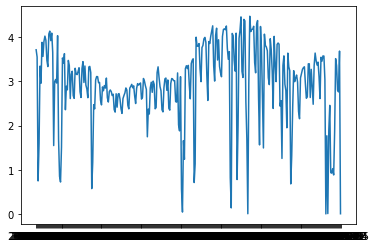

In [10]:
plt.plot(df_2)
plt.show()

In [11]:
from scipy.stats import zscore

In [12]:
values = df_2.to_numpy()
zscores = zscore(values)
median = df_2.median()
for i in range(len(values)):
    if zscores[i] > 2 or zscores[i] < -2:
        values[i] = median
df_2 = po.DataFrame(values)

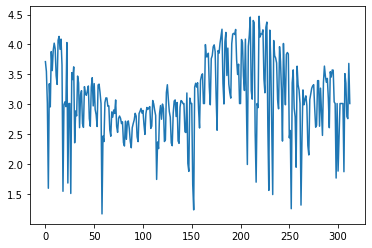

In [13]:
plt.plot(df_2)

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

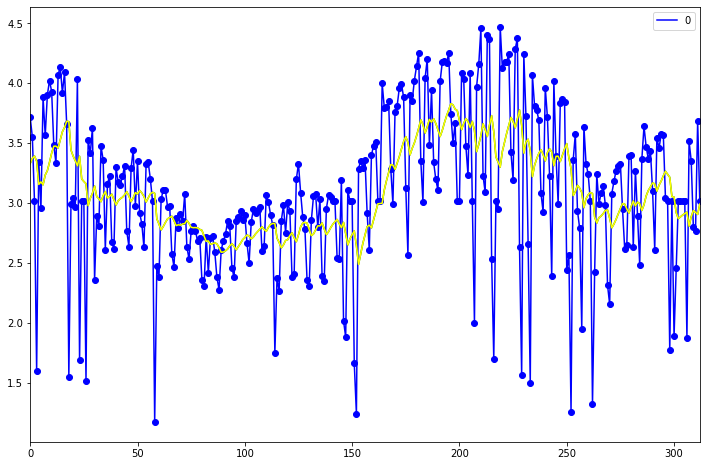

In [15]:
ax = df_2.plot(marker='o', color='blue', figsize=(12,8))
fit1 = SimpleExpSmoothing(df_2).fit()
fit2 = Holt(df_2, damped=True).fit()
fit1.fittedvalues.plot(ax=ax, color='green')
fit2.fittedvalues.plot(ax=ax, color='yellow')
plt.show()

In [16]:
df_3 = fit2.fittedvalues

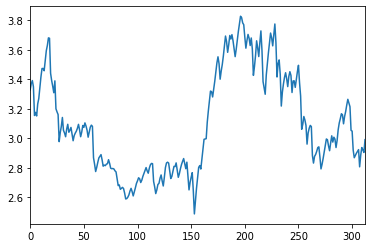

In [17]:
df_3.plot()

In [18]:
from numpy import polyfit

In [58]:
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(df_3))]
y = df_3.values
degree = 5
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)

Coefficients: [ 4.22370284e-11 -3.26240025e-08  8.50063457e-06 -8.22678808e-04
  1.94781998e-02  3.23098097e+00]


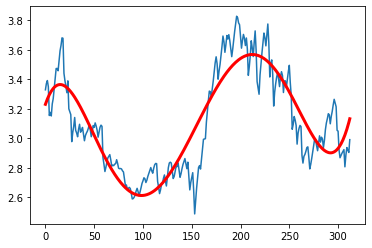

In [59]:
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(df_3.values)
plt.plot(curve, color='red', linewidth=3)
plt.show()

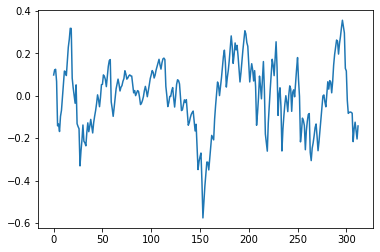

In [60]:
# create seasonally adjusted data
values = df_3.values
diff = list()
for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)
plt.plot(diff)
plt.show()

In [46]:
df_4 = po.DataFrame(diff)

In [40]:
df_4 = po.DataFrame(diff)
df_4.to_csv('data/cleaned_data.csv', index = False)